In [6]:
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from scipy.optimize import minimize, curve_fit, differential_evolution
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_folder = '/content/drive/MyDrive/csv_files_tys_2/csv_files_tys_2'
pic_folder = '/content/drive/MyDrive/svi_plots'
file_list = os.listdir(data_folder)

In [11]:
#df = pd.read_csv('/content/drive/MyDrive/SVI_adj_w=1.csv')
#df

In [13]:
data_ori_df = pd.read_csv(f'{data_folder}/spx_eod_202206.csv')
data_df = data_ori_df.copy()
data_df.loc[:, 'GREATER'] = data_df['STRIKE'] > data_df['F']
data_df.loc[:, 'IV'] = pd.concat([
    ((data_df['C_BID_IV'] + data_df['C_ASK_IV']) / 2 )[data_df['GREATER'].values],
    ((data_df['P_BID_IV'] + data_df['P_ASK_IV']) / 2)[~data_df['GREATER'].values]
    ])
data_df.loc[:, 'VEGA'] = pd.concat([data_df['C_VEGA'][data_df['GREATER'].values], data_df['P_VEGA'][~data_df['GREATER'].values]])
# data_df.dropna(subset=['IV'], inplace=True)
data_df.tail()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,C_MID,P_MID,S,C_ASK_IV,C_BID_IV,P_ASK_IV,P_BID_IV,GREATER,IV,VEGA
166905,1656619200,2022-06-30 16:00,2022-06-30,16.0,3789.1,2026-12-18,1797627600,1632.04,0.03476,0.00003,...,18.30,4123.0,3514.096967,0.200620,0.151917,0.326341,NaN,True,0.176269,6.25556
166906,1656619200,2022-06-30 16:00,2022-06-30,16.0,3789.1,2026-12-18,1797627600,1632.04,0.04088,0.00003,...,22.85,4265.6,3514.096967,0.202526,0.183243,0.318586,NaN,True,0.192884,7.06724
166907,1656619200,2022-06-30 16:00,2022-06-30,16.0,3789.1,2026-12-18,1797627600,1632.04,0.03875,0.00007,...,21.75,4474.5,3514.096967,0.204279,0.186901,0.340956,NaN,True,0.195590,6.77069
166908,1656619200,2022-06-30 16:00,2022-06-30,16.0,3789.1,2026-12-18,1797627600,1632.04,0.02733,0.00008,...,14.40,2467.3,3514.096967,0.207556,0.165332,0.336021,NaN,True,0.186444,5.09420
166909,1656619200,2022-06-30 16:00,2022-06-30,16.0,3789.1,2026-12-18,1797627600,1632.04,0.07135,0.00010,...,52.65,5160.2,3514.096967,0.277676,0.200392,0.360696,NaN,True,0.239034,10.90204


In [14]:
data_df.columns

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'F', 'RATE',
       'C_MID', 'P_MID', 'S', 'C_ASK_IV', 'C_BID_IV', 'P_ASK_IV', 'P_BID_IV',
       'GREATER', 'IV', 'VEGA'],
      dtype='object')

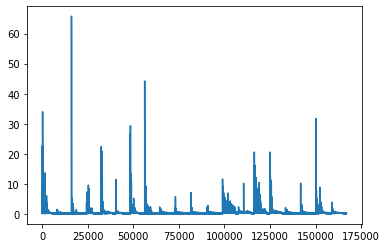

In [15]:
data_df['C_IV'].dropna().plot()

In [ ]:
#data_df['C_MID_IV'].dropna().plot()

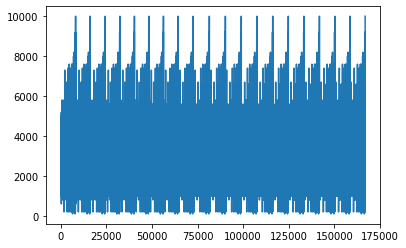

In [17]:
data_df['STRIKE'].dropna().plot()

In [ ]:
#data_df[['P_IV', 'P_MID_IV', 'P_ASK_IV', 'P_BID_IV', 'IV', 'P_MID', 'RATE']][(~data_df['GREATER'].values) & (~data_df['IV'].isna())]

In [18]:
np.log(data_df['STRIKE']/data_df['F'])[(~data_df['GREATER'].values) & (~data_df['IV'].isna())]

181      -1.411169
182      -1.228847
183      -1.074697
184      -0.941165
185      -0.823382
            ...   
166867   -0.128867
166868   -0.101469
166869   -0.074800
166870   -0.048825
166871   -0.023507
Length: 81604, dtype: float64

In [ ]:
#data_df[data_df['STRIKE'] < 1000][['P_IV', 'P_MID_IV', 'P_MID', 'F', 'RATE', 'STRIKE', 'UNDERLYING_LAST']]

In [19]:
#data_df[['P_IV', 'P_MID_IV', 'P_ASK_IV', 'P_BID_IV', 'IV', 'P_MID', 'RATE']][(data_df['GREATER'].values) & (~data_df['IV'].isna())]

In [20]:
data_ori_df.iloc[0]

QUOTE_UNIXTIME                1654113600
QUOTE_READTIME          2022-06-01 16:00
QUOTE_DATE                    2022-06-01
QUOTE_TIME_HOURS                    16.0
UNDERLYING_LAST                   4101.0
EXPIRE_DATE                   2022-06-01
EXPIRE_UNIX                   1654113600
DTE                                  0.0
C_DELTA                          0.99942
C_GAMMA                              0.0
C_VEGA                           0.00297
C_THETA                         -0.25007
C_RHO                            0.01953
C_IV                            10.11721
C_VOLUME                             NaN
C_LAST                               0.0
C_SIZE                             2 x 2
C_BID                             3100.5
C_ASK                             3102.0
STRIKE                            1000.0
P_BID                                0.0
P_ASK                               0.05
P_SIZE                           0 x 111
P_LAST                               0.0
P_DELTA         

In [31]:
[1] * 5

[1, 1, 1, 1, 1]

In [38]:
def raw_svi_func(k, a, b, rho, m, sigma):
    total_var = a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma ** 2))
    return total_var

def svi_var_func(param, args):
    a = param[0]
    b = param[1]
    rho = param[2]
    m = param[3]
    sigma = param[4]
    k = args[0]
    w = args[1]
    total_var = raw_svi_func(k, a, b, rho, m, sigma)
    variance = (total_var - w).var()
    return [variance] * len(w)

def raw_svi_loss_func(param, args, method='mse'):
    a = param[0]
    b = param[1]
    rho = param[2]
    m = param[3]
    sigma = param[4]
    k = args[0]
    w = args[1]
    if len(args) >= 3:
        weight = args[2]
    else:
        weight = np.ones(len(k))
    total_var = raw_svi_func(k, a, b, rho, m, sigma)
    if method == 'mse':
        #return ((total_var - w) ** 2 * weight).mean()
        t = []
        for x in range(len(k)):
          if k[x]>0:
            if total_var[x] > args[4][x]:
              t.append(((total_var[x] - w[x]) ** 2 + 30 * (total_var[x] - args[4][x]) ** 2)  * weight[x])
            elif total_var[x] < args[3][x]:
              t.append(((total_var[x] - w[x]) ** 2 + 30* (total_var[x] - args[3][x]) ** 2)  * weight[x])
            else:
              t.append((total_var[x] - w[x]) ** 2 * weight[x])
          else:
            if total_var[x] > args[6][x]:
              t.append(((total_var[x] - w[x]) ** 2 + 30 * (total_var[x] - args[6][x]) ** 2)  * weight[x])
            elif total_var[x] < args[5][x]:
              t.append(((total_var[x] - w[x]) ** 2 + 30 * (total_var[x] - args[5][x]) ** 2)  * weight[x])
            else:
              t.append((total_var[x] - w[x]) ** 2 * weight[x])
        return np.array(t).mean()
    else:
        return (abs(np.sqrt(total_var) - np.sqrt(w))).mean()

def stats_func(param, args):
    a = param[0]
    b = param[1]
    rho = param[2]
    m = param[3]
    sigma = param[4]
    k_all = args[0]
    k = args[1]
    w_c_bid = args[2]
    w_c_ask = args[3]
    w_p_bid = args[4]
    w_p_ask = args[5]
    w_fit = raw_svi_func(k, a, b, rho, m, sigma)
    c_spread = w_c_ask - w_c_bid
    p_spread = w_p_ask - w_p_bid
    fill_bid_ask = (sum((w_fit >= w_c_bid) & (w_fit <= w_c_ask) & (k > 0)) +\
        sum((w_fit >= w_p_bid) & (w_fit <= w_p_ask) & (k <= 0))) / len(k)
    fill_bid_ask_50 = (sum((w_fit >= w_c_bid - 0.5 * c_spread) & (w_fit <= w_c_ask + 0.5 * c_spread) & (k > 0)) +\
        sum((w_fit >= w_p_bid - 0.5 * p_spread) & (w_fit <= w_p_ask + 0.5 * p_spread) & (k <= 0))) / len(k)
    return fill_bid_ask, fill_bid_ask_50

def plot_func(param, args, label):
    zoom = 1.5
    a = param[0]
    b = param[1]
    rho = param[2]
    m = param[3]
    sigma = param[4]
    k_ar = np.arange(-zoom, zoom, 0.002)
    var_ar = raw_svi_func(k_ar, a, b, rho, m, sigma)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(k_ar, var_ar)
    for i in range(4):  # total 4 curves
        x = args[i]
        y = args[i+4]
        # y = y[(x > -zoom) & (x < zoom)]
        # x = x[(x > -zoom) & (x < zoom)]
        ax.scatter(x=x, y=y, s=10)
    plt.savefig(f'{pic_folder}/{label}.jpg')
    plt.close()

parameter_df = list()
# fit
date_se = data_df['QUOTE_DATE'].drop_duplicates()
for date in date_se:
    data_date_df = data_df[data_df['QUOTE_DATE'] == date]
    last_price = data_date_df["UNDERLYING_LAST"].mean()
    maturity_se = data_date_df['DTE'][data_date_df['DTE'] > 0].drop_duplicates()
    for maturity in tqdm(maturity_se[:]):
        if (maturity < 345) | (maturity > 375):
            continue
        data_mat_df = data_date_df[data_date_df['DTE'] == maturity]
        maturity = 365
        # fitting
        forward = data_mat_df['F']

        k_all = np.log(data_mat_df['STRIKE'] / forward).values
        k = np.log(data_mat_df['STRIKE'] / forward)[~data_mat_df['IV'].isna()].values
        w = (data_mat_df['IV'][~data_mat_df['IV'].isna()] ** 2).values

        weight = np.log(data_mat_df['VEGA'][~data_mat_df['IV'].isna()] + 1).values
        #weight = np.ones(len(data_mat_df[~data_mat_df['IV'].isna()]))
        theta = w[abs(k).argmin()]
        # p_opt, p_cov = curve_fit(raw_svi_func, k, w, maxfev=1000)
        # bounds
        bounds = [
            (None, None),
            (0, None),
            (-1, 1),
            (None, None),
            (0, None)
        ]
        # initial guess
        guess = [
            np.nanmin(w) / 2,
            0.1,
            -0.5,
            0.1,
            0.1
        ]
        # optimizer
        w_group = [
            # (data_mat_df[tag] ** 2 * maturity / 360).values
            ((data_mat_df[tag] ** 2)[~data_mat_df['IV'].isna()]).values
            for tag in ['C_BID_IV', 'C_ASK_IV', 'P_BID_IV', 'P_ASK_IV']
            ]
        res = minimize(
            raw_svi_loss_func,
            x0=guess,
            args=[k, w, weight] + w_group,
            # bounds=bounds,
            # method='CG',
            # options={'disp': True},
            tol=1e-4
        )
        # plot

        k_group = [k] * 4
        plot_func(
            res.x, 
            k_group + w_group, 
            f'{date}_{maturity}'
            )
        ## some stats
        fill, fill_50 = stats_func(res.x, [k_all, k]+w_group)
        parameter_dict = {
            'date': date, 
            'maturity': maturity, 
            'observation': len(data_mat_df),
            'success': res.success,
            'iteration': res.nit,
            'a': res.x[0],
            'b': res.x[1],
            'rho': res.x[2],
            'm': res.x[3],
            'sigma': res.x[4],
            'message': res.message,
            'loss': raw_svi_loss_func(res.x, [k, w, weight] + w_group),
            'mae': raw_svi_loss_func(res.x, [k, w], method='mae'),
            'theta': theta,
            'fill': fill,
            'fill_1.5': fill_50,
            'k': k.tolist(),
            'w': (w * maturity / 360).tolist(),
            'R_SE': svi_var_func(res.x, [k, w, weight] + w_group),
            'UNDERLYING_LAST': last_price
        }
        parameter_df.append(parameter_dict)
    print(f'{date} Finished!')

100%|██████████| 44/44 [00:00<00:00, 101.33it/s]


 2022-06-01 Finished!


100%|██████████| 44/44 [00:00<00:00, 66.17it/s]


 2022-06-02 Finished!


100%|██████████| 44/44 [00:00<00:00, 80.37it/s]


 2022-06-03 Finished!


100%|██████████| 43/43 [00:01<00:00, 22.80it/s]


 2022-06-06 Finished!


100%|██████████| 43/43 [00:01<00:00, 30.37it/s]


 2022-06-07 Finished!


100%|██████████| 43/43 [00:01<00:00, 35.94it/s]


 2022-06-08 Finished!


100%|██████████| 43/43 [00:00<00:00, 62.93it/s]


 2022-06-09 Finished!


100%|██████████| 43/43 [00:00<00:00, 86.12it/s]


 2022-06-10 Finished!


100%|██████████| 43/43 [00:00<00:00, 104.85it/s]


 2022-06-13 Finished!


100%|██████████| 43/43 [00:01<00:00, 31.56it/s]


 2022-06-14 Finished!


100%|██████████| 42/42 [00:00<00:00, 81.23it/s]


 2022-06-15 Finished!


100%|██████████| 42/42 [00:00<00:00, 75.98it/s]


 2022-06-16 Finished!


100%|██████████| 44/44 [00:00<00:00, 84.95it/s]


 2022-06-20 Finished!


100%|██████████| 44/44 [00:00<00:00, 65.09it/s]


 2022-06-21 Finished!


100%|██████████| 43/43 [00:00<00:00, 98.01it/s]


 2022-06-22 Finished!


100%|██████████| 44/44 [00:00<00:00, 65.28it/s]


 2022-06-23 Finished!


100%|██████████| 44/44 [00:00<00:00, 64.24it/s]


 2022-06-27 Finished!


100%|██████████| 44/44 [00:00<00:00, 59.53it/s]


 2022-06-28 Finished!


100%|██████████| 44/44 [00:00<00:00, 62.93it/s]


 2022-06-29 Finished!


100%|██████████| 44/44 [00:00<00:00, 70.07it/s]

 2022-06-30 Finished!


In [ ]:
#data_mat_df[['C_BID_IV', 'C_ASK_IV', 'C_ASK', 'C_BID', 'C_MID', 'C_MID_IV', 'RATE', 'S', 'STRIKE']]

In [39]:
parameter_df = pd.DataFrame(parameter_df)
parameter_df.to_csv('/content/drive/MyDrive/SVI_adj.csv')
parameter_df

,date,maturity,observation,success,iteration,a,b,rho,m,sigma,message,loss,mae,theta,fill,fill_1.5,k,w,R_SE,UNDERLYING_LAST
0,2022-06-01,365,138,True,106,-0.660038,0.662426,0.432594,0.906951,1.147842,Optimization terminated successfully.,0.000043,0.003324,0.049322,0.449275,0.746377,"[-3.032927898520493, -2.3397807179605477, -1.9...","[1.0442322089844283, 0.7182764288307062, 0.571...","[7.781341233244363e-05, 7.781341233244363e-05,...",4101.00
1,2022-06-02,365,138,True,126,-0.674531,0.658858,0.431955,0.934966,1.175800,Optimization terminated successfully.,0.000111,0.004642,0.050467,0.282609,0.492754,"[-3.0512948031168103, -2.358147622556865, -1.9...","[1.0442322089844283, 0.7099751264334552, 0.572...","[7.926837523833582e-05, 7.926837523833582e-05,...",4176.82
2,2022-06-03,365,138,True,133,-0.677101,0.682950,0.450693,0.954461,1.152379,Optimization terminated successfully.,0.000130,0.004696,0.052949,0.224638,0.442029,"[-3.034469928104947, -2.341322747545002, -1.93...","[1.0442322089844283, 0.7266259805739752, 0.574...","[8.009408328572263e-05, 8.009408328572263e-05,...",4107.84
3,2022-06-06,365,138,True,374,-0.809956,1.237096,0.701287,1.289043,0.946984,Optimization terminated successfully.,0.000113,0.004543,0.052093,0.210145,0.478261,"[-3.03859119976566, -2.3454440192057144, -1.93...","[1.034218054803543, 0.7224451735340884, 0.5781...","[9.074889016446692e-05, 9.074889016446692e-05,...",4120.92
4,2022-06-06,365,141,True,143,-0.845084,0.783621,0.510706,1.150391,1.292168,Optimization terminated successfully.,0.000166,0.004573,0.051811,0.163121,0.411348,"[-3.040098820500525, -2.3469516399405794, -1.9...","[1.0044650883369972, 0.6873953305314189, 0.546...","[4.7984054531270816e-05, 4.7984054531270816e-0...",4120.92
5,2022-06-07,365,138,True,226,-0.699135,0.955584,0.624531,1.127554,0.970601,Optimization terminated successfully.,0.000144,0.004927,0.051789,0.217391,0.442029,"[-3.047360004544653, -2.3542128239847075, -1.9...","[1.05429461251133, 0.7182764288307062, 0.57623...","[0.0001453694248685114, 0.0001453694248685114,...",4160.15
6,2022-06-07,365,141,True,146,-0.909045,0.848729,0.545631,1.237530,1.313706,Optimization terminated successfully.,0.000217,0.005025,0.050762,0.141844,0.375887,"[-3.0488398201366547, -2.3556926395767093, -1....","[1.0242521499686765, 0.6813005316429666, 0.544...","[7.760318572959503e-05, 7.760318572959503e-05,...",4160.15
7,2022-06-08,365,138,True,134,-0.727994,0.723643,0.482076,1.031414,1.187724,Optimization terminated successfully.,0.000178,0.005150,0.051846,0.195652,0.340580,"[-3.0367408709444064, -2.343593690384461, -1.9...","[1.034218054803543, 0.7120459286565787, 0.5678...","[8.211805390790938e-05, 8.211805390790938e-05,...",4115.98
8,2022-06-08,365,141,True,164,-1.028002,0.928987,0.574481,1.366797,1.385402,Optimization terminated successfully.,0.000243,0.005093,0.052002,0.113475,0.290780,"[-3.0382623645054436, -2.3451151839454982, -1....","[1.0044650883369972, 0.6813005316429666, 0.539...","[5.3219873395302987e-05, 5.3219873395302987e-0...",4115.98
9,2022-06-09,365,141,True,172,-0.922324,0.826662,0.528361,1.239447,1.352036,Optimization terminated successfully.,0.000198,0.005328,0.054397,0.170213,0.375887,"[-3.014012102470787, -2.320864921910842, -1.91...","[1.0143344944798283, 0.677252410304629, 0.5287...","[7.001573885441328e-05, 7.001573885441328e-05,...",4017.26


In [40]:
df1 = parameter_df.sort_values('fill',ascending=False).groupby("date").first()
df1.to_csv('/content/drive/MyDrive/SVI_adj.csv')
df1

,maturity,observation,success,iteration,a,b,rho,m,sigma,message,loss,mae,theta,fill,fill_1.5,k,w,R_SE,UNDERLYING_LAST
date,,,,,,,,,,,,,,,,,,,
2022-06-01,365,138,True,106,-0.660038,0.662426,0.432594,0.906951,1.147842,Optimization terminated successfully.,0.000043,0.003324,0.049322,0.449275,0.746377,"[-3.032927898520493, -2.3397807179605477, -1.9...","[1.0442322089844283, 0.7182764288307062, 0.571...","[7.781341233244363e-05, 7.781341233244363e-05,...",4101.00
2022-06-02,365,138,True,126,-0.674531,0.658858,0.431955,0.934966,1.175800,Optimization terminated successfully.,0.000111,0.004642,0.050467,0.282609,0.492754,"[-3.0512948031168103, -2.358147622556865, -1.9...","[1.0442322089844283, 0.7099751264334552, 0.572...","[7.926837523833582e-05, 7.926837523833582e-05,...",4176.82
2022-06-03,365,138,True,133,-0.677101,0.682950,0.450693,0.954461,1.152379,Optimization terminated successfully.,0.000130,0.004696,0.052949,0.224638,0.442029,"[-3.034469928104947, -2.341322747545002, -1.93...","[1.0442322089844283, 0.7266259805739752, 0.574...","[8.009408328572263e-05, 8.009408328572263e-05,...",4107.84
2022-06-06,365,138,True,374,-0.809956,1.237096,0.701287,1.289043,0.946984,Optimization terminated successfully.,0.000113,0.004543,0.052093,0.210145,0.478261,"[-3.03859119976566, -2.3454440192057144, -1.93...","[1.034218054803543, 0.7224451735340884, 0.5781...","[9.074889016446692e-05, 9.074889016446692e-05,...",4120.92
2022-06-07,365,138,True,226,-0.699135,0.955584,0.624531,1.127554,0.970601,Optimization terminated successfully.,0.000144,0.004927,0.051789,0.217391,0.442029,"[-3.047360004544653, -2.3542128239847075, -1.9...","[1.05429461251133, 0.7182764288307062, 0.57623...","[0.0001453694248685114, 0.0001453694248685114,...",4160.15
2022-06-08,365,138,True,134,-0.727994,0.723643,0.482076,1.031414,1.187724,Optimization terminated successfully.,0.000178,0.005150,0.051846,0.195652,0.340580,"[-3.0367408709444064, -2.343593690384461, -1.9...","[1.034218054803543, 0.7120459286565787, 0.5678...","[8.211805390790938e-05, 8.211805390790938e-05,...",4115.98
2022-06-09,365,141,True,172,-0.922324,0.826662,0.528361,1.239447,1.352036,Optimization terminated successfully.,0.000198,0.005328,0.054397,0.170213,0.375887,"[-3.014012102470787, -2.320864921910842, -1.91...","[1.0143344944798283, 0.677252410304629, 0.5287...","[7.001573885441328e-05, 7.001573885441328e-05,...",4017.26
2022-06-10,365,141,True,114,-0.735923,0.700779,0.477643,1.080683,1.241903,Optimization terminated successfully.,0.000133,0.004553,0.058378,0.226950,0.411348,"[-2.9861291589995784, -2.292981978439633, -1.8...","[0.9995484787703387, 0.6833291156883246, 0.540...","[8.297201866684334e-05, 8.297201866684334e-05,...",3900.16
2022-06-13,365,141,True,92,-0.525129,0.593350,0.408445,0.861740,1.028849,Optimization terminated successfully.,0.000046,0.003677,0.063798,0.390071,0.730496,"[-2.949197261756732, -2.2560500811967867, -1.8...","[1.0044650883369972, 0.7203592933903342, 0.545...","[8.297494285038256e-05, 8.297494285038256e-05,...",3750.95


In [ ]:
df = pd.concat([df,df1])
df = df.groupby("date").first()
df = df.sort_index()
df.to_csv('/content/drive/MyDrive/SVI_adj_2022.csv')
df

,maturity,observation,success,iteration,a,b,rho,m,sigma,message,loss,mae,theta,fill,fill_1.5,k,w
date,,,,,,,,,,,,,,,,,
2022-01-03,361.0,122,True,34,-0.033553,0.159664,-0.515131,0.126673,0.354818,Optimization terminated successfully.,0.000141,0.005583,0.036933,0.616667,0.941667,"[-1.7860739609521492, -1.5629304096379395, -1....","[0.5738450491082931, 0.41095285475403076, 0.30..."
2022-01-04,360.0,123,True,31,-0.007056,0.142379,-0.512140,0.148341,0.221137,Optimization terminated successfully.,0.000131,0.008606,0.043293,0.940678,1.000000,"[-1.7861566271067293, -1.5630130757925196, -1....","[0.35299292857795944, 0.25237162591973317, 0.2..."
2022-01-05,359.0,123,True,15,-0.007638,0.142503,-0.510631,-0.004780,0.158045,Optimization terminated successfully.,0.000222,0.007511,0.009918,0.483051,0.644068,"[-1.7691512170444317, -1.546007665730222, -1.3...","[0.33700295240041994, 0.33717971293911947, 0.3..."
2022-01-06,358.0,123,True,30,-0.020659,0.148227,-0.523418,0.151152,0.302701,Optimization terminated successfully.,0.000126,0.006725,0.042461,0.902439,1.000000,"[-1.7658073833962986, -1.542663832082089, -1.3...","[0.4484996245196688, 0.40676176780493867, 0.35..."
2022-01-07,357.0,123,True,25,-0.013802,0.127780,-0.511586,0.113198,0.257474,Optimization terminated successfully.,0.000321,0.010365,0.024314,0.982609,1.000000,"[-1.7640029006587157, -1.540859349344506, -1.3...","[0.4186839551415755, 0.3649354260684912, 0.288..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,372.0,62,True,33,-0.114220,0.184549,-0.693924,-0.022614,0.940286,Optimization terminated successfully.,0.000247,0.003697,0.056610,0.758065,0.951613,"[-1.5748281002170164, -1.3516845489028066, -1....","[0.44677783352886635, 0.373420041571281, 0.170..."
2022-06-27,368.0,62,True,36,-0.139393,0.190522,-0.750534,-0.100108,1.089366,Optimization terminated successfully.,0.000005,0.001099,0.055586,0.629032,0.951613,"[-1.601969539897009, -1.3788259885827991, -1.1...","[0.43870111558748603, 0.3701545277915355, 0.31..."
2022-06-28,367.0,62,True,34,-0.090086,0.177835,-0.640789,0.034372,0.787606,Optimization terminated successfully.,0.000102,0.003076,0.053737,0.596774,0.935484,"[-1.581340359120879, -1.358196807806669, -1.17...","[0.4342573592918407, 0.24814936493598272, 0.31..."


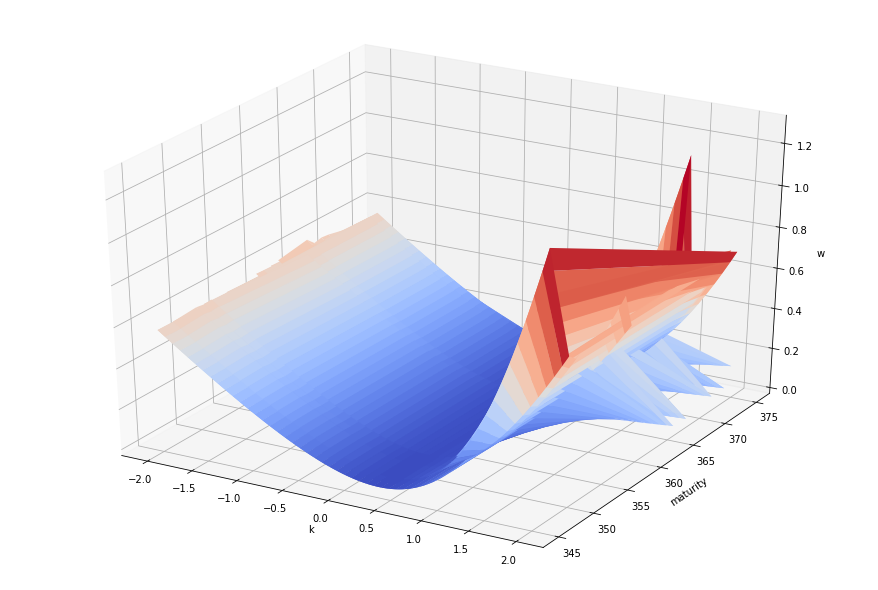

In [ ]:
plot_df = parameter_df.iloc[:]
k_ar = np.arange(-2, 2, 0.01)
z = plot_df.apply(lambda row: pd.Series(raw_svi_func(k_ar, row['a'], row['b'], row['rho'], row['m'], row['sigma'])), axis=1).values
x = np.tile(k_ar, (len(plot_df), 1))
y = np.tile(plot_df['maturity'].values, (len(k_ar), 1)).T
# y = np.tile(np.arange(len(plot_df)), (len(k_ar), 1)).T
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)
ax.set_ylabel('maturity')
ax.set_xlabel('k')
ax.set_zlabel('w')
ax.plot_surface(x, y, z, linewidth=0.2, cmap=cm.coolwarm)

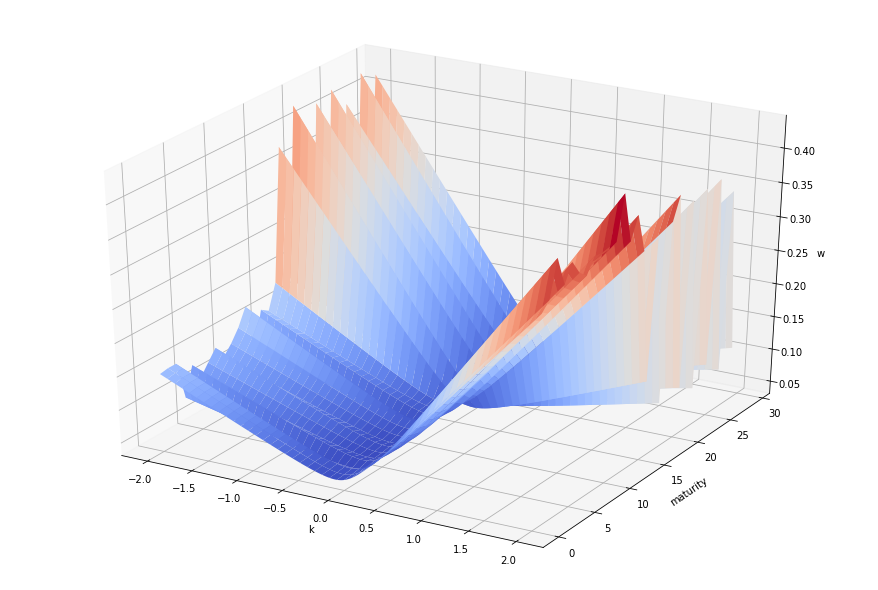

In [ ]:
# ssvi
plot_df = parameter_df.iloc[:]
k_ar = np.arange(-2, 2, 0.01)
theta_t = np.tile(plot_df['theta'].values, (len(k_ar), 1)).T
rho_t = np.tile(plot_df['rho'].values, (len(k_ar), 1)).T
phi_t = 1 / (theta_t ** 0.5 * (1 + theta_t) ** 0.5)
k_t = np.tile(k_ar, (len(plot_df), 1)).flatten()
x = np.tile(k_ar, (len(plot_df), 1))
z = theta_t / 2 * (1 + rho_t * phi_t * x + np.sqrt((phi_t * x) ** 2 + 1 - rho_t ** 2))
# y = np.tile(plot_df['maturity'].values, (len(k_ar), 1)).T
y = np.tile(np.arange(len(plot_df)), (len(k_ar), 1)).T
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig)
ax.set_ylabel('maturity')
ax.set_xlabel('k')
ax.set_zlabel('w')
ax.plot_surface(x, y, z, linewidth=0.2, cmap=cm.coolwarm)

In [ ]:
phi_t

array([[4.39568078, 4.39568078, 4.39568078, ..., 4.39568078, 4.39568078,
        4.39568078],
       [4.34316545, 4.34316545, 4.34316545, ..., 4.34316545, 4.34316545,
        4.34316545],
       [4.23512619, 4.23512619, 4.23512619, ..., 4.23512619, 4.23512619,
        4.23512619],
       ...,
       [4.09328543, 4.09328543, 4.09328543, ..., 4.09328543, 4.09328543,
        4.09328543],
       [4.09553361, 4.09553361, 4.09553361, ..., 4.09553361, 4.09553361,
        4.09553361],
       [4.03461709, 4.03461709, 4.03461709, ..., 4.03461709, 4.03461709,
        4.03461709]])

In [ ]:
k_ar = np.arange(-2, 2, 0.01)
z = parameter_df.apply(lambda row: pd.Series(raw_svi_func(k_ar, row['a'], row['b'], row['rho'], row['m'], row['sigma'])), axis=1).values.flatten()
x = np.tile(k_ar, (1, len(parameter_df))).flatten()
y = np.tile(parameter_df['maturity'].values, (len(k_ar), 1)).flatten()

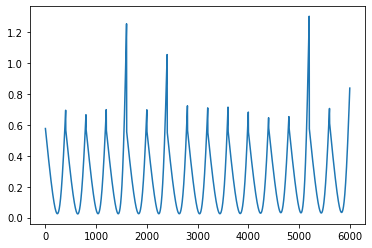

In [ ]:
plt.plot(z[:int(len(z)/2)])

In [ ]:
X = np.arange(-5, 5, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(X.shape)
print(Y.shape)
print(Z.shape)

(40, 200)
(40, 200)
(40, 200)


In [ ]:
X

array([[-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95],
       [-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95],
       [-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95],
       ...,
       [-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95],
       [-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95],
       [-5.  , -4.95, -4.9 , ...,  4.85,  4.9 ,  4.95]])